# POSE pipeline

(Single-modal) In this tutorial, we demonstrate how to perform the POSE pipeline on Breast Cancer (BC) RNA data from TCGA. This analysis entails the following:

1. Upload data
2. Compute pairwise sample (WE) distances with respect to gene neigborhoods 
3. Compute global pairwise sample (WE) distance matrices
4. Convert global distances to a single sample pairwise similarity matrix
5. (Future work - dpt distance and/or multi-scale diffusion based distances)
6. Extract pseudo-organization (i.e., ordering) of samples.
7. Determine schema (i.e., branching).
8. Visualize schema
9. (Future work - further investigation into samples within different branches and differential analysis between branches)

- $d_W(i,j,v)$ - The Wasserstein distance of the 1-hop neighborhood around gene $v$ between sample $i$ and sample $j$
- $d_E(i,j,v)$ - The Euclidean distance of the 1-hop neighborhood around gene $v$ between sample $i$ and sample $j$
- $D_W(i,j) = |d_W(i,j,v)|$ - Net Wasserstein distance between sample $i$ and sample $j$ wrt all genes $v$
- $D_E(i,j) = |d_E(i,j,v)|$ - Net Euclidean distance between sample $i$ and sample $j$ wrt all genes $v$
- $K_W = e^{-\frac{\|D_W\|^2}{\sigma^2}}$ - Pairwise sample Wasserstein similarity matrix 
- $K_E = e^{-\frac{\|D_E\|^2}{\sigma^2}}$ - Pairwise sample Euclidean similarity matrix 
- (Multi-feature, multi-modal) $K = \frac{K_W + K_E}{2}$ - Fused pairwise sample similarity matrix
- $D = 1 - K$ - Fused pairwise sample distance matrix
- (Clustering) Determine branching according to lineage tracing algorithm using $D$ 
- (Visualizing) Pseudo-ordering of samples in branches according to distance from root node $r$, i.e., $D(r,:)$

First, import the necessary packages:

# Load libraries

In [74]:
import pathlib
import sys

import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sc_sparse

If ``netflow`` has not been installed, add the path to the library:

In [2]:
sys.path.insert(0, pathlib.Path(pathlib.Path('.').absolute()).parents[3].resolve().as_posix())
# sys.path.insert(0, pathlib.Path(pathlib.Path('.').absolute()).parents[0].resolve().as_posix())

From the ``netflow`` package, we load the following modules:
 - The ``InfoNet`` class is used to compute 1-hop neighborhood distances
 - The ``Keeper`` class is used to store and manipulate data/results

In [3]:
import netflow as nf

# from netflow.keepers import keeper 

# Load data

In [4]:
INPUT_DIR = pathlib.Path('/Volumes/DeasyLab3/Rena/KevinM_TCGA_BRCA_immuneTDA/')
RNA_FNAME = INPUT_DIR / 'TCGA_BRCA_TPM.txt'
CIBERSORT_FNAME = INPUT_DIR / 'tcga_cibersort_tda.py'
CLIN_FNAME = INPUT_DIR / 'TCGA_BRCA_clin.csv'
CLIN_SMALL_FNAME = INPUT_DIR / 'TCGA_BRCA_clin_reduced.csv'

RNA_HPRD_FNAME = INPUT_DIR / 'TCGA_BRCA_TPM_HPRD.txt'
E_HPRD_FNAME = INPUT_DIR / 'edgelist_HPRD_TCGA_BRCA_TPM.csv'
# E_FNAME = '/Users/renae12/Library/CloudStorage/OneDrive-MemorialSloanKetteringCancerCenter/!GDriveMigratedData/My Documents/MSKCC/data/multiple_myeloma_apoptosis_ASK/data/E_apop140.csv'

## Restrict to HPRD network (only perform once)

In [5]:
HPRD_FNAME = '/Users/renae12/Documents/MSKCC/dev/GeometricNetworkAnalysis/data/simple_connected_topologies/HPRD_simple_connected.csv'

In [6]:
E = pd.read_csv(HPRD_FNAME, header=0)
G = nx.from_pandas_edgelist(E)
print(G)

Graph with 9188 nodes and 36682 edges


In [7]:
X = pd.read_csv(RNA_FNAME, header=0, index_col=0, sep='\t')

In [8]:
X.shape

(35347, 1111)

Remove genes that have zero expression for all samples:

In [9]:
X = X.loc[X.max(axis=1) > 1e-6]
X.shape

(34251, 1111)

In [12]:
print(f"{len(set(G) & set(X.index))} out of {len(set(X.index))} genes in RNA data")

8544 out of 34168 genes in RNA data


In [13]:
G = G.subgraph(list(set(G) & set(X.index)))
print(G)

Graph with 8544 nodes and 33785 edges


In [14]:
print(f"Largest connected subgraph has {len(max(nx.connected_components(G), key=len))} nodes")

Largest connected subgraph has 8449 nodes


In [15]:
G = G.subgraph(max(nx.connected_components(G), key=len))
print(G)

Graph with 8449 nodes and 33778 edges


In [16]:
X = X.loc[list(G)]
print(X.shape)

(8472, 1111)


Duplicate genes (probably from ensembl id:

Take sum of TPM values -- references: 

- This post says it is ok to add TPM, sort of tersely: https://www.biostars.org/p/9551799/
- This post says the same thing, more descriptive: https://www.biostars.org/p/397198/
- Qiagen says so too: https://qiagen.my.salesforce-sites.com/KnowledgeBase/KnowledgeNavigatorPage?id=kA46N000000k9ifSAA&categoryName=OmicSoft_Suite,OmicSoft_Lands#:~:text=The%20sum%20of%20ALL%20normalized,level%20TPM%20for%20each%20gene

In [17]:
gl = []
for a,b in X.reset_index()[['Gene']].groupby('Gene'):
    if b.shape[0] > 1:
        gl.append(a)
        
print(len(gl))
print(*sorted(gl), sep=', ')

23
BAZ2B, CHN2, CLEC4A, COMMD7, CRHR1, CYB561D2, DET1, FAM50B, GGT1, HLA-DQA1, LGALS7, MATR3, MYO18A, NPAS4, POLA2, PTP4A1, RAET1E, RGS5, SCHIP1, SEC16B, SMN1, ST6GALNAC6, TBCE


In [18]:
X = X.reset_index().groupby('Gene').sum()

In [19]:
X.shape

(8449, 1111)

In [20]:
E = pd.DataFrame(data=list(G.edges()), columns=['source', 'target'])
print(E.shape)

(33778, 2)


In [21]:
X.to_csv(RNA_HPRD_FNAME, header=True, index=True)
E.to_csv(E_HPRD_FNAME, header=True, index=False)

## Load pretty data

First set output directory:

In [5]:
outdir = pathlib.Path('/Users/renae12/OneDrive - Memorial Sloan Kettering Cancer Center/!GDriveMigratedData/My Documents/MSKCC/projects/KevinM_TCGA_BRCA_immuneTDA')
if not outdir.is_dir():
    outdir.mkdir()                      

In [6]:
X = pd.read_csv(RNA_HPRD_FNAME, header=0, index_col=0)
print(X.shape)

(8449, 1111)


In [7]:
E = pd.read_csv(E_HPRD_FNAME, header=0)
G = nx.from_pandas_edgelist(E)
print(G)

Graph with 8449 nodes and 33778 edges


Upload data to the keeper:

In [8]:
# results = keeper.Keeper(data={'rna': X})

data_label = 'rna'
keeper = nf.Keeper(data={data_label: X}, outdir=outdir)
keeper._check_observation_labels()
keeper._check_num_observations()

Add the PPI network to the misc data for storage and later reference.

In [9]:
graph_label = 'PPI'
keeper.add_misc(G, graph_label)

MSG      Added misc input PPI to the keeper.

## Load pathways

In [10]:
PATHWAY_FNAME = pathlib.Path('/Users/renae12/Documents/MSKCC/data/KEGG_pathways_from_OHJ/c2.cp.kegg.v5.2.symbols.xlsx')

In [11]:
pathways = pd.read_excel(PATHWAY_FNAME, header=None, index_col=0)
pathways.head(2)

1    \
0                                                                                    
KEGG_GLYCOLYSIS_GLUCONEOGENESIS  http://www.broadinstitute.org/gsea/msigdb/card...   
KEGG_CITRATE_CYCLE_TCA_CYCLE     http://www.broadinstitute.org/gsea/msigdb/card...   

                                   2     3     4     5     6      7      8    \
0                                                                              
KEGG_GLYCOLYSIS_GLUCONEOGENESIS  ACSS2   GCK  PGK2  PGK1  PDHB  PDHA1  PDHA2   
KEGG_CITRATE_CYCLE_TCA_CYCLE     IDH3B  DLST  PCK2    CS  PDHB   PCK1  PDHA1   

                                       9      10   ...  381  382  383  384  \
0                                                  ...                       
KEGG_GLYCOLYSIS_GLUCONEOGENESIS       PGM2   TPI1  ...  NaN  NaN  NaN  NaN   
KEGG_CITRATE_CYCLE_TCA_CYCLE     LOC642502  PDHA2  ...  NaN  NaN  NaN  NaN   

                                 385  386  387  388  389  390  
0                                                              
KEGG_GLYCOLYSIS_GLUCONEOGENESIS  NaN  NaN  NaN  NaN  NaN  NaN  
KEGG_CITRATE_CYCLE_TCA_CYCLE     NaN  NaN  NaN  NaN  NaN  NaN  

[2 rows x 390 columns]

In [12]:
pathways = pathways.drop(columns=1)
pathways.head(2)

2     3     4     5     6      7      8    \
0                                                                              
KEGG_GLYCOLYSIS_GLUCONEOGENESIS  ACSS2   GCK  PGK2  PGK1  PDHB  PDHA1  PDHA2   
KEGG_CITRATE_CYCLE_TCA_CYCLE     IDH3B  DLST  PCK2    CS  PDHB   PCK1  PDHA1   

                                       9      10         11   ...  381  382  \
0                                                             ...             
KEGG_GLYCOLYSIS_GLUCONEOGENESIS       PGM2   TPI1      ACSS1  ...  NaN  NaN   
KEGG_CITRATE_CYCLE_TCA_CYCLE     LOC642502  PDHA2  LOC283398  ...  NaN  NaN   

                                 383  384  385  386  387  388  389  390  
0                                                                        
KEGG_GLYCOLYSIS_GLUCONEOGENESIS  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
KEGG_CITRATE_CYCLE_TCA_CYCLE     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[2 rows x 389 columns]

In [13]:
# print(*sorted(pathways.index), sep='\n')

pws = ['KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY',
       'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY',
       'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY']

In [14]:
pw_features = set()
for pw in pws:
    pw_features = pw_features | set(pathways.loc[pw].values.tolist()) - set([np.nan])
    print(len(pw_features))

75
171
216


In [15]:
pw_features = list(pw_features & set(G))
print(len(pw_features))

193


# Compute pairwise-sample 1-hop Wasserstein distances

In [16]:
inet = nf.methods.classes.InfoNet(keeper, graph_label, layer=data_label,
                  label='pw_sample_1hop_wass', outdir=None)

MSG      Loaded graph: Graph with 8449 nodes and 33778 edges

MSG      Loaded data: (8449, 1111)

In [17]:
print(inet.G)
for i in range(len(G)):
    if i not in inet.G:
        print(i)
# print('--------')        
# for ix, i in enumerate(sorted(G)):
#     if ix != i:
#         print(ix, i)

Graph with 8449 nodes and 33778 edges


In [18]:
inet.features == list(range(len(G)))

True

In [19]:
dhop = inet.compute_graph_distances(weight=None)

In [20]:
inet.multiple_pairwise_observation_neighborhood_wass_distance(graph_distances=dhop, 
                                                              nodes=pw_features,
                                                              include_self=False,
                                                              label='rna_pw_obs_nbhd_wass_dist',
                                                              desc='Computing pairwise 1-hop distances',
                                                              profiles_desc='t0')

MSG      Loaded saved observation pairwise 1-hop neighborhood Wasserstein distances from t0 profiles of size       
         (616605, 182).

MSG      Added misc input rna_pw_obs_nbhd_wass_dist to the keeper.

# Compute pairwise-sample 1-hop Euclidean distances

In [21]:
inet.multiple_pairwise_observation_neighborhood_euc_distance(nodes=pw_features,
                                                             include_self=True,
                                                             label='rna_pw_obs_nbhd_euc_dist',
                                                             desc='Computing pairwise 1-hop distances',
                                                             profiles_desc='t0')

MSG      Loaded saved observation pairwise 1-hop neighborhood Euclidean distances from t0 profiles of size (616605,
         182).

MSG      Added misc input rna_pw_obs_nbhd_euc_dist to the keeper.

# Compute pairwise-sample profile Wasserstein distances

# Compute pairwise-sample profile Euclidean distances

# Convert multi-feature distances to single distance via norm:

In [22]:
# compute norm of distances as vector:
# nf.methods.metrics.norm_features(keeper, 'rna_pw_obs_nbhd_wass_dist', label='norm_rna_pw_obs_nbhd_wass_dist')
# nf.methods.metrics.norm_features(keeper, 'rna_pw_obs_nbhd_euc_dist', label='norm_rna_pw_obs_nbhd_euc_dist')

# convert norm to distance matrix (used to be po.compute_norm_features()):
nf.methods.metrics.norm_features_as_sym_dist(keeper, 'rna_pw_obs_nbhd_wass_dist', label='norm_rna_pw_obs_nbhd_wass_dist',
                                             features=None, method='L1', is_distance=True)
nf.methods.metrics.norm_features_as_sym_dist(keeper, 'rna_pw_obs_nbhd_euc_dist', label='norm_rna_pw_obs_nbhd_euc_dist',
                                             features=None, method='L1', is_distance=True)

MSG      Added distance input norm_rna_pw_obs_nbhd_wass_dist to the keeper.

MSG      Added distance input norm_rna_pw_obs_nbhd_euc_dist to the keeper.

# Compute similarities from distances
- $\sigma$ : Kernel width representing each data point's accessible neighbors. 
- Set $\sigma$ normalization for each obs as the distance to its k-th neighbor : $$K_{ij} = \sqrt{\frac{2\sigma_i\sigma_j}{\sigma_i^2 + \sigma_j^2}}e^{-\frac{|d_{ij}^2|}{2(\sigma_i^2 + \sigma_j^2)}}$$
where for each observation $i$, $\sigma_i$ is the distance to its $k$-th nearest neighbor.

In [23]:
# compute sigmas:
nf.similarity.sigma_knn(keeper, 'norm_rna_pw_obs_nbhd_wass_dist', 
                             label='max5nn_norm_rna_pw_obs_nbhd_wass_dist', 
                             n_neighbors=5, method='max', return_nn=True)
nf.similarity.sigma_knn(keeper, 'norm_rna_pw_obs_nbhd_euc_dist', 
                             label='max5nn_norm_rna_pw_obs_nbhd_euc_dist', 
                             n_neighbors=5, method='max', return_nn=True)



MSG      Added misc input sigmas_max5nn_norm_rna_pw_obs_nbhd_wass_dist to the keeper.

MSG      Added misc input nn_indices_max5nn_norm_rna_pw_obs_nbhd_wass_dist to the keeper.

MSG      Added misc input nn_distances_max5nn_norm_rna_pw_obs_nbhd_wass_dist to the keeper.

MSG      Added misc input sigmas_max5nn_norm_rna_pw_obs_nbhd_euc_dist to the keeper.

MSG      Added misc input nn_indices_max5nn_norm_rna_pw_obs_nbhd_euc_dist to the keeper.

MSG      Added misc input nn_distances_max5nn_norm_rna_pw_obs_nbhd_euc_dist to the keeper.

In [24]:
# compute similarities:
nf.similarity.distance_to_similarity(keeper, 'norm_rna_pw_obs_nbhd_wass_dist', 
                                     5, 'max',
                                     label='similarity_max5nn_norm_rna_pw_obs_nbhd_wass_dist', 
                                     sigmas='sigmas_max5nn_norm_rna_pw_obs_nbhd_wass_dist', 
                                     knn=False, 
                                     indices='nn_indices_max5nn_norm_rna_pw_obs_nbhd_wass_dist')

nf.similarity.distance_to_similarity(keeper, 'norm_rna_pw_obs_nbhd_euc_dist', 
                                     5, 'max',
                                     label='similarity_max5nn_norm_rna_pw_obs_nbhd_euc_dist', 
                                     sigmas='sigmas_max5nn_norm_rna_pw_obs_nbhd_euc_dist', 
                                     knn=False, 
                                     indices='nn_indices_max5nn_norm_rna_pw_obs_nbhd_euc_dist')

MSG      Added similarity input similarity_max5nn_norm_rna_pw_obs_nbhd_wass_dist to the keeper.

MSG      Added similarity input similarity_max5nn_norm_rna_pw_obs_nbhd_euc_dist to the keeper.

In [25]:
# combine and add similarities:
fused_similarity = 0.5*(keeper.similarities['similarity_max5nn_norm_rna_pw_obs_nbhd_wass_dist'].data + \
                        keeper.similarities['similarity_max5nn_norm_rna_pw_obs_nbhd_euc_dist'].data)

fused_key = 'fused_similarity_max5nn_norm_rna_pw_obs_nbhd_wass_euc_dist'
keeper.add_similarity(fused_similarity, fused_key)

MSG      Added similarity input fused_similarity_max5nn_norm_rna_pw_obs_nbhd_wass_euc_dist to the keeper.

- save 1 - fused_similarity as fused distance:

In [26]:
keeper.add_distance(1.-fused_similarity, fused_key)

MSG      Added distance input fused_similarity_max5nn_norm_rna_pw_obs_nbhd_wass_euc_dist to the keeper.

In [45]:
import seaborn as sns

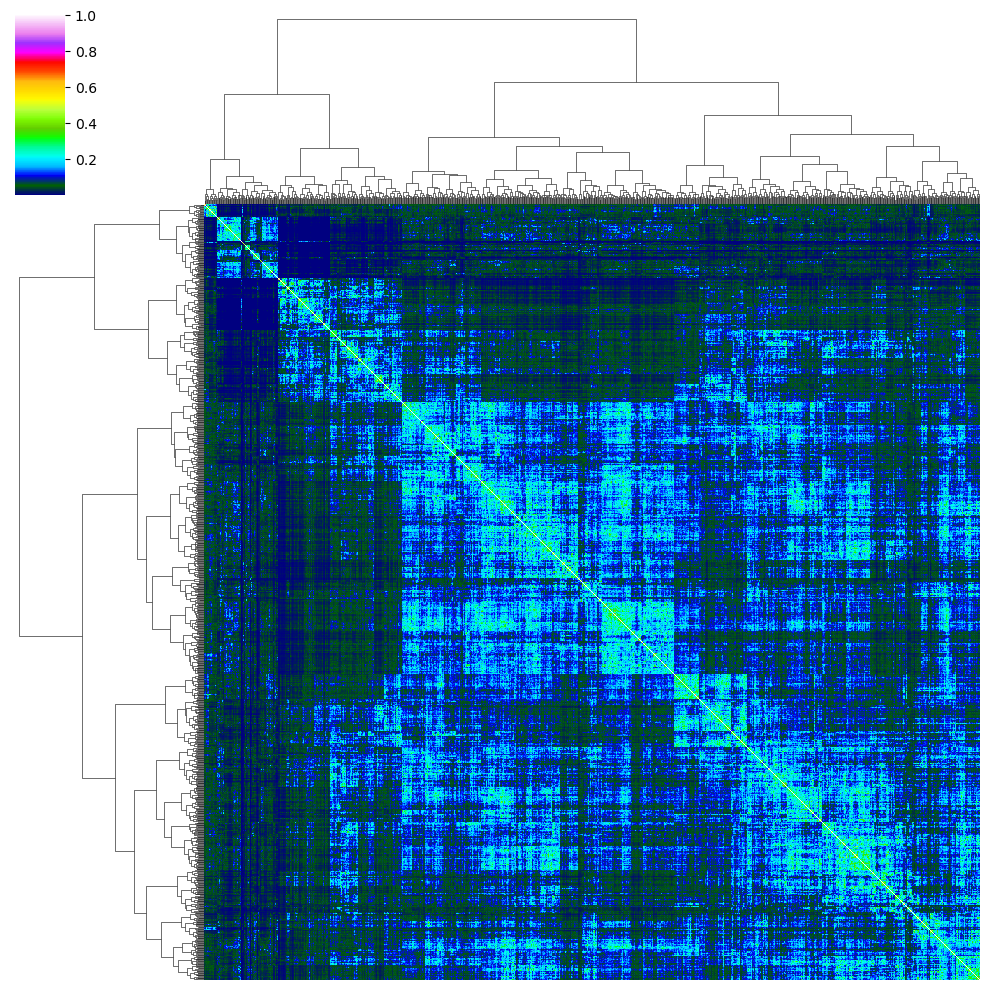

In [55]:
sns.clustermap(pd.DataFrame(data=keeper.similarities[fused_key].data,
             index=keeper.observation_labels, columns=keeper.observation_labels),
              yticklabels=0, xticklabels=0, method='ward', cmap='gist_ncar')

# Compute pseudo-ordering

In [59]:
tda_we = nf.organization.TDA(keeper, fused_key, label='testing',  
                             root=113, smooth_corr=True)
n_branches = 5 # 7
tda_we.branchings_segments(n_branches)

WARNING  *ibranch = 0

WARNING  *1 segs = [array([   0,    1,    2, ..., 1108, 1109, 1110])]

WARNING  *ibranch = 1

WARNING  *4 segs = [array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   11,                       
                  12,   13,   14,   15,   16,   18,   19,   20,   22,   27,   28,                                  
                  29,   30,   31,   32,   33,   34,   35,   36,   38,   39,   40,                                  
                  41,   42,   44,   46,   47,   48,   49,   50,   53,   55,   56,                                  
                  57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,                                  
                  68,   69,   71,   73,   75,   78,   79,   80,   81,   83,   84,                                  
                  85,   86,   87,   89,   90,   91,   92,   93,   94,   95,   96,                                  
                  97,   99,  100,  101,  102,  103,  105,  107,  108,  109,  110,                                  
                 111,  113,  116,  117,  118,  119,  120,  121,  127,  128,  129,                                  
                 130,  132,  133,  135,  137,  138,  139,  140,  141,  142,  143,                                  
                 144,  146,  148,  149,  150,  151,  152,  155,  156,  157,  161,                                  
                 162,  163,  164,  165,  166,  168,  169,  170,  171,  172,  174,                                  
                 176,  177,  178,  179,  181,  182,  183,  184,  186,  187,  188,                                  
                 189,  190,  191,  192,  193,  194,  195,  196,  197,  198,  200,                                  
                 201,  202,  203,  204,  208,  210,  213,  215,  217,  218,  219,                                  
                 220,  222,  223,  227,  228,  229,  231,  236,  237,  241,  242,                                  
                 243,  244,  245,  246,  248,  249,  251,  252,  255,  257,  260,                                  
                 263,  264,  265,  266,  267,  268,  269,  270,  272,  273,  274,                                  
                 275,  276,  279,  280,  281,  282,  283,  284,  285,  287,  288,                                  
                 290,  291,  293,  294,  295,  297,  298,  299,  301,  302,  303,                                  
                 305,  306,  309,  310,  311,  312,  313,  314,  316,  317,  318,                                  
                 319,  320,  321,  324,  325,  326,  327,  329,  330,  331,  333,                                  
                 335,  336,  337,  338,  340,  341,  344,  345,  347,  350,  351,                                  
                 352,  353,  354,  356,  358,  360,  361,  363,  365,  366,  369,                                  
                 370,  371,  372,  373,  374,  375,  376,  377,  378,  379,  380,                                  
                 381,  382,  383,  384,  385,  386,  387,  389,  390,  391,  392,                                  
                 393,  395,  396,  398,  399,  401,  402,  403,  407,  408,  410,                                  
                 411,  412,  413,  414,  415,  416,  417,  418,  419,  421,  422,                                  
                 423,  425,  426,  427,  428,  430,  431,  432,  433,  434,  435,                                  
                 437,  438,  439,  440,  441,  442,  444,  446,  449,  451,  452,                                  
                 453,  454,  455,  456,  457,  458,  459,  461,  462,  463,  464,                                  
                 465,  466,  467,  468,  469,  470,  471,  472,  474,  476,  477,                                  
                 478,  479,  481,  482,  483,  484,  485,  486,  487,  488,  490,                                  
                 491,  492,  493,  494,  496,  498,  499,  501,  502,  503,  504,                                  
                 505,  506,  507,  508,  509,  511,  512

WARNING      is root itself, never obtain significant correlation

WARNING  Unique segment is empty, removing from consideration and no branching performed.

WARNING  No unique branch detected - removed from consideration.

WARNING  No further branching occured at this iteration.

WARNING  *ibranch = 2

WARNING  *4 segs = [array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   11,                       
                  12,   13,   14,   15,   16,   18,   19,   20,   22,   27,   28,                                  
                  29,   30,   31,   32,   33,   34,   35,   36,   38,   39,   40,                                  
                  41,   42,   44,   46,   47,   48,   49,   50,   53,   55,   56,                                  
                  57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,                                  
                  68,   69,   71,   73,   75,   78,   79,   80,   81,   83,   84,                                  
                  85,   86,   87,   89,   90,   91,   92,   93,   94,   95,   96,                                  
                  97,   99,  100,  101,  102,  103,  105,  107,  108,  109,  110,                                  
                 111,  113,  116,  117,  118,  119,  120,  121,  127,  128,  129,                                  
                 130,  132,  133,  135,  137,  138,  139,  140,  141,  142,  143,                                  
                 144,  146,  148,  149,  150,  151,  152,  155,  156,  157,  161,                                  
                 162,  163,  164,  165,  166,  168,  169,  170,  171,  172,  174,                                  
                 176,  177,  178,  179,  181,  182,  183,  184,  186,  187,  188,                                  
                 189,  190,  191,  192,  193,  194,  195,  196,  197,  198,  200,                                  
                 201,  202,  203,  204,  208,  210,  213,  215,  217,  218,  219,                                  
                 220,  222,  223,  227,  228,  229,  231,  236,  237,  241,  242,                                  
                 243,  244,  245,  246,  248,  249,  251,  252,  255,  257,  260,                                  
                 263,  264,  265,  266,  267,  268,  269,  270,  272,  273,  274,                                  
                 275,  276,  279,  280,  281,  282,  283,  284,  285,  287,  288,                                  
                 290,  291,  293,  294,  295,  297,  298,  299,  301,  302,  303,                                  
                 305,  306,  309,  310,  311,  312,  313,  314,  316,  317,  318,                                  
                 319,  320,  321,  324,  325,  326,  327,  329,  330,  331,  333,                                  
                 335,  336,  337,  338,  340,  341,  344,  345,  347,  350,  351,                                  
                 352,  353,  354,  356,  358,  360,  361,  363,  365,  366,  369,                                  
                 370,  371,  372,  373,  374,  375,  376,  377,  378,  379,  380,                                  
                 381,  382,  383,  384,  385,  386,  387,  389,  390,  391,  392,                                  
                 393,  395,  396,  398,  399,  401,  402,  403,  407,  408,  410,                                  
                 411,  412,  413,  414,  415,  416,  417,  418,  419,  421,  422,                                  
                 423,  425,  426,  427,  428,  430,  431,  432,  433,  434,  435,                                  
                 437,  438,  439,  440,  441,  442,  444,  446,  449,  451,  452,                                  
                 453,  454,  455,  456,  457,  458,  459,  461,  462,  463,  464,                                  
                 465,  466,  467,  468,  469,  470,  471,  472,  474,  476,  477,                                  
                 478,  479,  481,  482,  483,  484,  485,  486,  487,  488,  490,                                  
                 491,  492,  493,  494,  496,  498,  499,  501,  502,  503,  504,                                  
                 505,  506,  507,  508,  509,  511,  512

WARNING      is root itself, never obtain significant correlation

WARNING  segment is more than 95\% correlated.

WARNING  detected group with only 1 data points

WARNING  *ibranch = 3

WARNING  *7 segs = [array([   1,    9,   12,   16,   27,   30,   33,   36,   40,   49,   55,                       
                  63,   67,   71,   90,   91,   92,   94,   95,   97,  113,  117,                                  
                 118,  121,  127,  128,  130,  139,  142,  143,  148,  155,  157,                                  
                 168,  171,  177,  181,  182,  183,  186,  195,  201,  204,  208,                                  
                 210,  213,  219,  229,  242,  244,  246,  251,  264,  273,  274,                                  
                 275,  279,  283,  285,  297,  298,  305,  310,  312,  316,  317,                                  
                 327,  333,  347,  350,  361,  370,  386,  389,  392,  398,  402,                                  
                 419,  435,  439,  452,  455,  456,  457,  458,  463,  469,  471,                                  
                 474,  487,  490,  509,  511,  518,  522,  525,  536,  544,  546,                                  
                 548,  552,  557,  559,  561,  567,  570,  575,  593,  594,  599,                                  
                 605,  616,  626,  627,  630,  634,  642,  648,  651,  654,  665,                                  
                 668,  674,  676,  698,  718,  721,  722,  730,  739,  742,  754,                                  
                 755,  757,  760,  767,  769,  778,  788,  794,  798,  800,  802,                                  
                 804,  827,  828,  829,  831,  837,  840,  846,  853,  854,  859,                                  
                 868,  869,  880,  898,  905,  909,  910,  913,  923,  928,  934,                                  
                 935,  936,  952,  956,  968,  970,  971,  978,  989,  999, 1001,                                  
                1004, 1006, 1018, 1021, 1030, 1031, 1033, 1046, 1049, 1050, 1052,                                  
                1053, 1061, 1063, 1068, 1093, 1102]), array([  25,   43,   51,   72,   88,  114,  123,  126,  147, 
         180,  205,                                                                                                
                 214,  221,  235,  240,  250,  254,  256,  262,  277,  289,  292,                                  
                 322,  323,  339,  346,  349,  406,  409,  436,  447,  497,  510,                                  
                 514,  532,  549,  577,  578,  606,  673,  681,  709,  726,  751,                                  
                 753,  768,  777,  801,  810,  830,  836,  844,  861,  900,  903,                                  
                 918,  926,  937,  947,  958,  969,  975,  976, 1042, 1067, 1069,                                  
                1070, 1073, 1080, 1086, 1097, 1104]), array([  21,   70,   82,  112,  134,  167,  173,  185,  209, 
         211,  224,                                                                                                
                 238,  286,  296,  304,  328,  332,  343,  364,  368,  394,  420,                                  
                 424,  443,  448,  460,  480,  495,  603,  607,  618,  625,  633,                                  
                 659,  697,  713,  731,  734,  740,  921,  954,  972,  981,  984,                                  
                1010, 1056, 1062, 1075, 1106]), array([   7,   17,   23,   26,   37,   45,   52,   54,   74,   76, 
         77,                                                                                                       
                  98,  104,  115,  122,  125,  131,  136,  145,  153,  158,  159,                                  
                 160,  175,  199,  206,  207,  212,  225,  226,  230,  232,  233,                                  
                 234,  239,  247,  253,  258,  259,  261,  271,  278,  300,  308,                                  
                 315,  334,  342,  348,  355,  359,  362

WARNING  *ibranch = 4

WARNING  *10 segs = [array([   1,    9,   12,   16,   27,   30,   33,   36,   40,   49,   55,                      
                  63,   67,   71,   90,   91,   92,   94,   95,   97,  113,  117,                                  
                 118,  121,  127,  128,  130,  139,  142,  143,  148,  155,  157,                                  
                 168,  171,  177,  181,  182,  183,  186,  195,  201,  204,  208,                                  
                 210,  213,  219,  229,  242,  244,  246,  251,  264,  273,  274,                                  
                 275,  279,  283,  285,  297,  298,  305,  310,  312,  316,  317,                                  
                 327,  333,  347,  350,  361,  370,  386,  389,  392,  398,  402,                                  
                 419,  435,  439,  452,  455,  456,  457,  458,  463,  469,  471,                                  
                 474,  487,  490,  509,  511,  518,  522,  525,  536,  544,  546,                                  
                 548,  552,  557,  559,  561,  567,  570,  575,  593,  594,  599,                                  
                 605,  616,  626,  627,  630,  634,  642,  648,  651,  654,  665,                                  
                 668,  674,  676,  698,  718,  721,  722,  730,  739,  742,  754,                                  
                 755,  757,  760,  767,  769,  778,  788,  794,  798,  800,  802,                                  
                 804,  827,  828,  829,  831,  837,  840,  846,  853,  854,  859,                                  
                 868,  869,  880,  898,  905,  909,  910,  913,  923,  928,  934,                                  
                 935,  936,  952,  956,  968,  970,  971,  978,  989,  999, 1001,                                  
                1004, 1006, 1018, 1021, 1030, 1031, 1033, 1046, 1049, 1050, 1052,                                  
                1053, 1061, 1063, 1068, 1093, 1102]), array([  25,   43,   51,   72,   88,  114,  123,  126,  147, 
         180,  205,                                                                                                
                 214,  221,  235,  240,  250,  254,  256,  262,  277,  289,  292,                                  
                 322,  323,  339,  346,  349,  406,  409,  436,  447,  497,  510,                                  
                 514,  532,  549,  577,  578,  606,  673,  681,  709,  726,  751,                                  
                 753,  768,  777,  801,  810,  830,  836,  844,  861,  900,  903,                                  
                 918,  926,  937,  947,  958,  969,  975,  976, 1042, 1067, 1069,                                  
                1070, 1073, 1080, 1086, 1097, 1104]), array([  21,   70,  112,  185,  424,  443,  460,  633,       
         1056]), array([   7,   17,   23,   26,   37,   45,   52,   54,   74,   76,   77,                          
                  98,  104,  115,  122,  125,  131,  136,  145,  153,  158,  159,                                  
                 160,  175,  199,  206,  207,  212,  225,  226,  230,  232,  233,                                  
                 234,  239,  247,  253,  258,  259,  261,  271,  278,  300,  308,                                  
                 315,  334,  342,  348,  355,  359,  362,  367,  388,  404,  405,                                  
                 429,  445,  450,  473,  489,  500,  513,  521,  524,  537,  572,                                  
                 612,  614,  617,  647,  663,  671,  685,  686,  695,  699,  706,                                  
                 719,  729,  738,  748,  786,  795,  803,  808,  815,  816,  821,                                  
                 822,  834,  835,  850,  860,  865,  867,  870,  873,  879,  883,                                  
                 889,  891,  892,  916,  924,  939,  943

WARNING  segment is more than 95\% correlated.

WARNING  Unique segment is empty, removing from consideration and no branching performed.

WARNING  No unique branch detected - removed from consideration.

WARNING  No further branching occured at this iteration.

In [64]:
for i in range(6):
    print(i, (tda_we.segs_names==i).sum())

0 193
1 72
2 9
3 123
4 4
5 650


In [65]:
G_tda = tda_we.construct_topology()
print(G_tda)

Graph with 1111 nodes and 1090 edges


In [66]:
tda_we.ordered_segs()

[array([ 113,  626,   63,  778,  800,  279,  742,  648,   27,  718,  333,
         935,  457,  788,  910,  999,  148,  487,   33,  909,  757, 1033,
         594,  370,  130,  182,  201,   71, 1006,  968, 1102,  548, 1004,
         599,  978,  275,  128,  829,  298,  471,  559,  722,  177,  794,
         402,   16,  831,  934,  956,  310,  676,  570, 1053,  769,  840,
         630,  474, 1061,  552,   67,  456, 1063,  827, 1050,  730, 1018,
         846,  674,  305,  143,  452,  127,  327,  208,  204,  186,  285,
         854,  971,  859,  435,  522,  246,  229,  171,  518,  575,  347,
         455,  905, 1046,  142,  469,   92, 1031,   49,  898,   90,  754,
         157,  350,  386,  139,  536, 1049,  274,  210,  509,  389,  439,
         642,  561,   40,  264,  853,  118,  837,  398,    9,  219,  312,
          97,  868, 1093,  213,  928,  297,  936,  155,  316,  544,  567,
         361,  419,  634,  802, 1030,  244,  970,  392,   94,   12,   91,
          95,  665,   36,  798, 1068, 

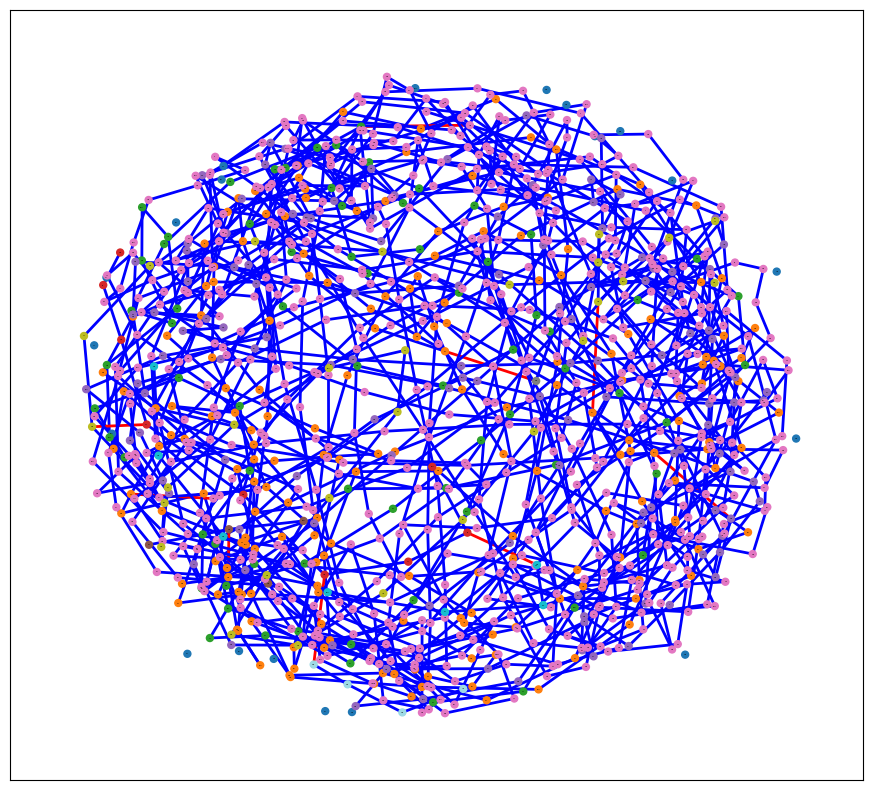

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(11,10))
pos = nx.layout.spring_layout(G_tda, k=.13)
nx.draw_networkx(G_tda, pos=pos, with_labels=True,
                 nodelist=list(G_tda), edgelist=list(G_tda.edges()),
                 # node_size=[100 if G_tda.nodes[k]['branch'] == -1 else 300 if G_tda.nodes[k]['undecided'] else 444 for k in G_tda],
                 node_size=25,
                 node_color=[G_tda.nodes[k]['branch'] for k in G_tda],
                 cmap='tab20', 
                 # labels={k: G_tda.nodes[k]['name'] for k in G_tda},
                 font_size=1, # 10, 
                 width=2, 
                 edge_color=['b' if G_tda.edges[k]['connection'] == 'intra-branch' else 'r' for k in G_tda.edges()],
                 ax=ax)

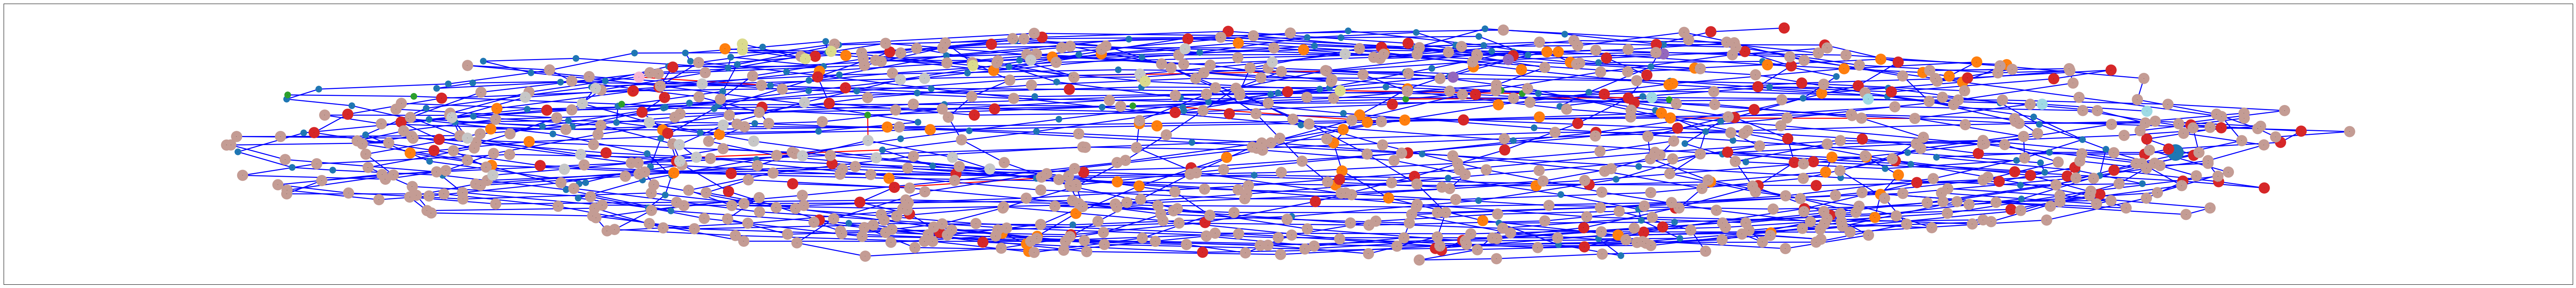

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(91,10))
GG = G_tda.subgraph([k for k in G_tda if G_tda.nodes[k]['branch']>-1])
pos = nx.layout.spring_layout(GG, k=.09)
nx.draw_networkx(GG, pos=pos, with_labels=True,
                 nodelist=list(GG), edgelist=list(GG.edges()),
                 node_size=[1000 if k == tda_we.root else 50 if GG.nodes[k]['branch'] == -1 else 150 if GG.nodes[k]['undecided'] else 444 for k in GG],
                 node_color=[GG.nodes[k]['branch'] for k in GG],
                 cmap='tab20', 
                 # labels={k: GG.nodes[k]['name'] for k in GG},
                 font_size=1, # 10, 
                 width=2, 
                 edge_color=['b' if GG.edges[k]['connection'] == 'intra-branch' else 'r' for k in GG.edges()],
                 ax=ax)

## Second reconstruction:

In [78]:
G_tda = nx.Graph()

if tda_we.segs_names_unique[0] == -1:
    x0 = tda_we.changepoints[0]
    changepoints = tda_we.changepoints[1:]
else: 
    x0 = 0
    changepoints = tda_we.changepoints
    
segs = []
for x1 in changepoints:
    segs.append(tda_we.indices[x0:x1])
    x0 = x1
segs.append(tda_we.indices[x0:])
# print(segs)
# # print(tda_we.segs_tips)

# add missing nodes
missing_nodes = set((range(tda_we.distances.shape[0]))) - set(itertools.chain(*segs))
print(f"{len(missing_nodes)} missing nodes")
G_tda.add_nodes_from(list(missing_nodes), branch=-1)
nx.set_node_attributes(G_tda, {k: False for k in missing_nodes}, name='undecided')
# nx.set_node_attributes(G_tda, {k: -1 for k in missing_nodes}, name='branch')
print(G_tda)


# add edges within branch:
# G_tda.add_edges_from(list(itertools.chain(*[[(k[i], k[i+1]) for i in range(k.size-1)] for k in segs])))
# print(G_tda)
for ix, seg in enumerate(segs):
    print(f"{ix}: {seg}")
    G_tda.add_edges_from(zip(seg, seg[1:]), connection='intra-branch')
    if len(seg) == 1:
        G_tda.add_node(seg[0])        
    nx.set_node_attributes(G_tda, {v: {'branch': ix, 'undecided': tda_we.segs_undecided[ix]} for v in seg})    
    
print(G_tda)
# print(G_tda.edges())
# print(G_tda.edges[(85,63)])
# print(G_tda.nodes[41], G_tda.nodes[82])

# print(sorted(G_tda))
# # add edges between branches
segs_connects_triu = sc_sparse.triu(tda_we.segs_connects).tocsr()
rows, cols = segs_connects_triu.nonzero()
inter_branch_edges = [(tda_we.segs_connects[r, c], tda_we.segs_connects[c, r]) for r, c in zip(rows, cols)]
G_tda.add_edges_from(inter_branch_edges, connection='inter-branch')
print(G_tda)
# print(sorted(G_tda))

nx.set_node_attributes(G_tda, dict(zip(range(keeper.num_observations), 
                                       keeper.observation_labels)), name='name')
# print(G_tda.nodes[0], G_tda.nodes[len(tda_we.index_labels)-1])    

20 missing nodes
Graph with 20 nodes and 0 edges
0: [ 113  626   63  778  800  279  742  648   27  718  333  935  457  788
  910  999  148  487   33  909  757 1033  594  370  130  182  201   71
 1006  968 1102  548 1004  599  978  275  128  829  298  471  559  722
  177  794  402   16  831  934  956  310  676  570 1053  769  840  630
  474 1061  552   67  456 1063  827 1050  730 1018  846  674  305  143
  452  127  327  208  204  186  285  854  971  859  435  522  246  229
  171  518  575  347  455  905 1046  142  469   92 1031   49  898   90
  754  157  350  386  139  536 1049  274  210  509  389  439  642  561
   40  264  853  118  837  398    9  219  312   97  868 1093  213  928
  297  936  155  316  544  567  361  419  634  802 1030  244  970  392
   94   12   91   95  665   36  798 1068  317  989  458  181  721  668
 1021  511  767  605  117   30  923  654  546  195   55  168  755  739
  463  869  593  251  490  804  828  616  525  557  242    1  183  913
  651  698  273  952  121

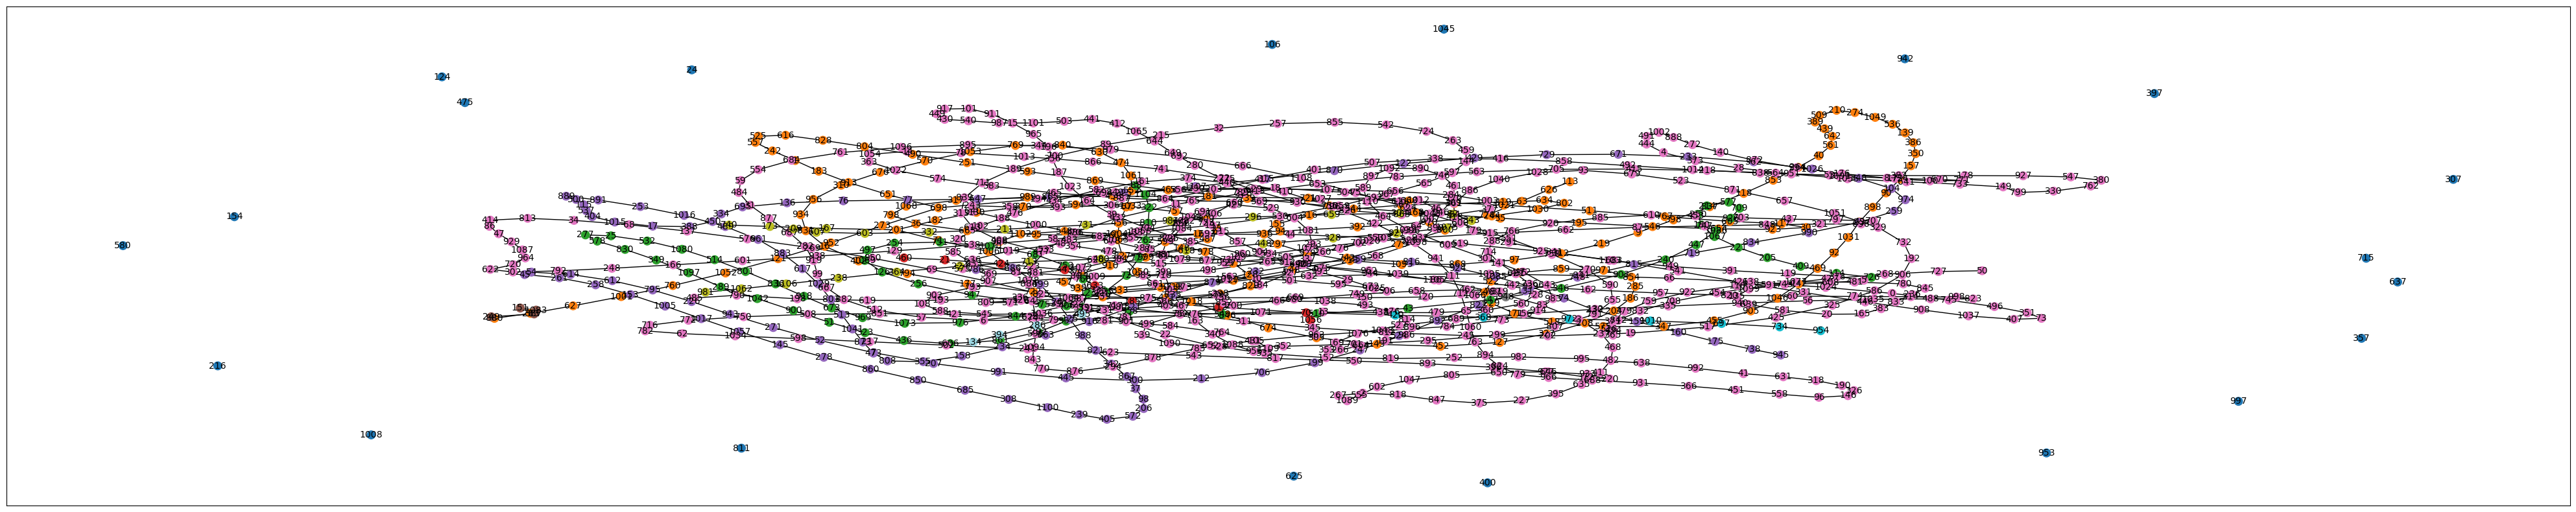

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(51,10))
pos = None
nx.draw_networkx(G_tda, pos=pos, with_labels=True,
                 nodelist=list(G_tda), edgelist=list(G_tda.edges()),
                 node_size=80,# 644, 
                 node_color=[G_tda.nodes[k]['branch'] for k in G_tda],
                 cmap='tab20', 
                 # labels={k: G_tda.nodes[k]['name'] for k in G_tda},
                 font_size=10, # edge_color
                 ax=ax)

In [86]:
G_tda = nx.Graph()

# add edges within branch
G_tda.add_edges_from(list(itertools.chain(*[[(k[i], k[i+1]) for i in range(k.size-1)] for k in tda_we.segs])))
print(G_tda)
# aa = set(G_tda)
# add edges between branches
segs_connects_triu = sc_sparse.triu(tda_we.segs_connects).tocsr()
G_tda.add_edges_from([(tda_we.segs_connects[r, c], tda_we.segs_connects[c, r]) for r, c in zip(rows, cols)])
print(G_tda)
# print(set(G_tda) - aa)
# set(itertools.chain(*[(tda_we.segs_connects[r, c], tda_we.segs_connects[c, r]) for r, c in zip(rows, cols)])) - set(itertools.chain(*tda_we.segs))

missing_nodes = set((range(tda_we.distances.shape[0]))) - set(itertools.chain(*tda_we.segs))
print(f"{len(missing_nodes)} missing nodes")
G_tda.add_nodes_from(list(missing_nodes))
nx.set_node_attributes(G_tda, {k: False for k in missing_nodes}, name='undecided')
nx.set_node_attributes(G_tda, {k: -1 for k in missing_nodes}, name='branch')
      
      
nx.set_node_attributes(G_tda, dict(zip(range(keeper.num_observations), 
                                       keeper.observation_labels)), name='name')
for ix, seg in enumerate(tda_we.segs):
    nx.set_node_attributes(G_tda, {k: ix for k in seg}, name='branch')
# tda_we.segs_tips

for seg, l in zip(tda_we.segs, tda_we.segs_undecided):
    if l:
        nx.set_node_attributes(G_tda, {k: True for k in seg}, name='undecided')
    else:
        nx.set_node_attributes(G_tda, {k: False for k in seg}, name='undecided')




Graph with 2 nodes and 3 edges
Graph with 20 nodes and 12 edges
1109 missing nodes


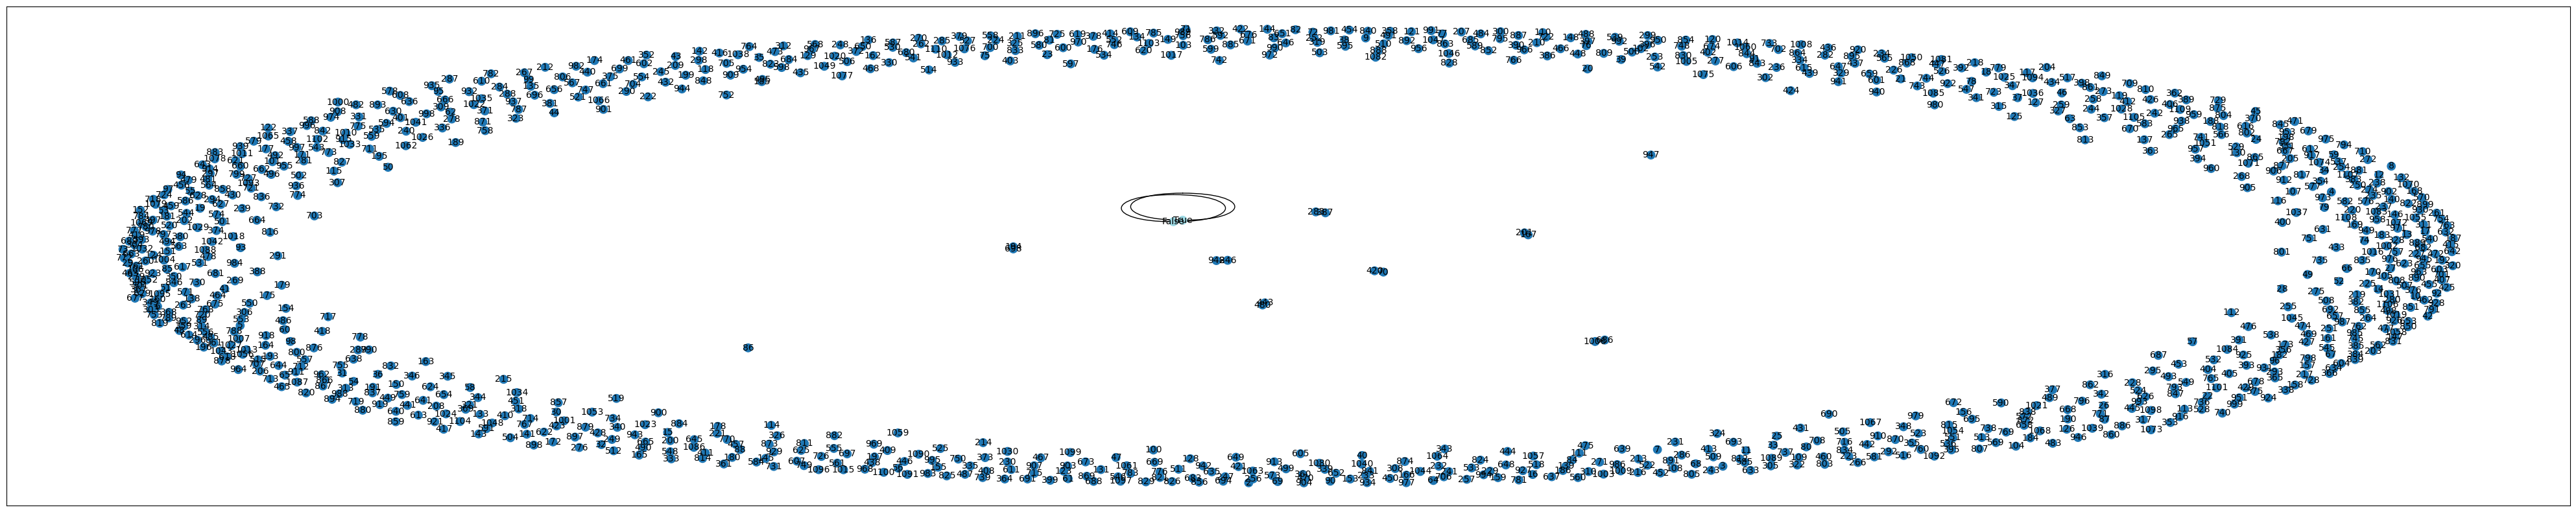

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(51,10))
pos = None
nx.draw_networkx(G_tda, pos=pos, with_labels=True,
                 nodelist=list(G_tda), edgelist=list(G_tda.edges()),
                 node_size=80,# 644, 
                 node_color=[G_tda.nodes[k]['branch'] for k in G_tda],
                 cmap='tab20', 
                 # labels={k: G_tda.nodes[k]['name'] for k in G_tda},
                 font_size=10, # edge_color
                 ax=ax)